Statistics packages

In [434]:
import numpy as np
import os
import pyreadr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import torch
# import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# import tensorflow as tf

sns.set()


HAVOK packages

In [435]:
import numpy as np
from scipy import integrate
from matplotlib.gridspec import GridSpec

import pykoopman as pk
from pykoopman.common import lorenz

Setup training and testing data

In [436]:
train_normal_path = './Dataset/TEP_FaultFree_Training.RData'
train_faulty_path = './Dataset/TEP_Faulty_Training.RData'

test_normal_path = './Dataset/TEP_FaultFree_Testing.RData'
test_faulty_path = './Dataset/TEP_Faulty_Testing.RData'


train_df = pyreadr.read_r(train_normal_path)['fault_free_training']    # (250000, 55)
test_df = pyreadr.read_r(test_faulty_path)['faulty_testing']

In [437]:
train_df.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


simulationRun = 1 | faultNumber = 0 (faultless)  dataset 설정
샘플이 총 500개있음. 500 샘플을 시간축으로 간주함.

In [438]:
feature_names = train_df.columns[3:44]
train_normal_df = train_df[(train_df.faultNumber==0)&(train_df.simulationRun.isin(range(21)))][feature_names]   # (500, 52)
X_np = train_normal_df.to_numpy()

dt = 0.1
n_states = len(train_normal_df.columns)
t_max = len(train_normal_df.index)
t = np.arange(1, t_max+1, dt)

In [439]:
def generate_list_increasing_by_dt(size, dt=0.1):
    output_list = []
    current_value = 0.1

    for _ in range(size):
        output_list.append(current_value)
        current_value += dt

    return np.array(output_list)

t = generate_list_increasing_by_dt(size=t_max, dt=dt)

Scaler

In [440]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = pd.DataFrame(scaler.fit_transform(X = train_normal_df))
train_df_scaled
# X_np = train_df_scaled.to_numpy()


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.513586,0.579929,0.588911,0.315368,0.434343,0.498828,0.483431,0.420420,0.600000,0.526609,...,0.482116,0.503325,0.503170,0.472388,0.489146,0.464056,0.524838,0.496392,0.519638,0.430199
1,0.516648,0.522015,0.682218,0.632860,0.328283,0.600821,0.497076,0.450372,0.600000,0.506188,...,0.482116,0.503325,0.503170,0.472388,0.489146,0.464056,0.524838,0.496392,0.519638,0.430199
2,0.513586,0.525585,0.415822,0.659317,0.425505,0.304220,0.520468,0.400306,0.666667,0.500309,...,0.544595,0.580632,0.485303,0.493643,0.709600,0.464056,0.524838,0.496392,0.519638,0.430199
3,0.510955,0.529552,0.531778,0.716479,0.351641,0.300117,0.539961,0.499344,0.466667,0.499278,...,0.544595,0.580632,0.485303,0.493643,0.709600,0.464056,0.524838,0.496392,0.519638,0.430199
4,0.701932,0.599762,0.480730,0.488649,0.434343,0.644197,0.499025,0.535199,0.466667,0.404290,...,0.248968,0.539485,0.249568,0.446166,0.351664,0.464056,0.524838,0.496392,0.519638,0.430199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.607824,0.495042,0.611900,0.560346,0.433712,0.622509,0.578947,0.577175,0.533333,0.351485,...,0.564943,0.523275,0.280115,0.462455,0.501688,0.521021,0.677731,0.436654,0.351309,0.702517
9996,0.426680,0.335581,0.540568,0.509881,0.307449,0.484174,0.534113,0.518146,0.466667,0.479992,...,0.489425,0.362843,0.226513,0.437028,0.566811,0.521021,0.677731,0.436654,0.351309,0.702517
9997,0.420685,0.438318,0.510142,0.564266,0.356061,0.468347,0.500975,0.505028,0.600000,0.478238,...,0.489425,0.362843,0.226513,0.437028,0.566811,0.521021,0.677731,0.436654,0.351309,0.702517
9998,0.474036,0.325268,0.635565,0.524579,0.534722,0.330598,0.502924,0.536948,0.400000,0.557446,...,0.793076,0.460515,0.717579,0.418951,0.549928,0.521021,0.677731,0.436654,0.351309,0.702517


Plot state trajectories

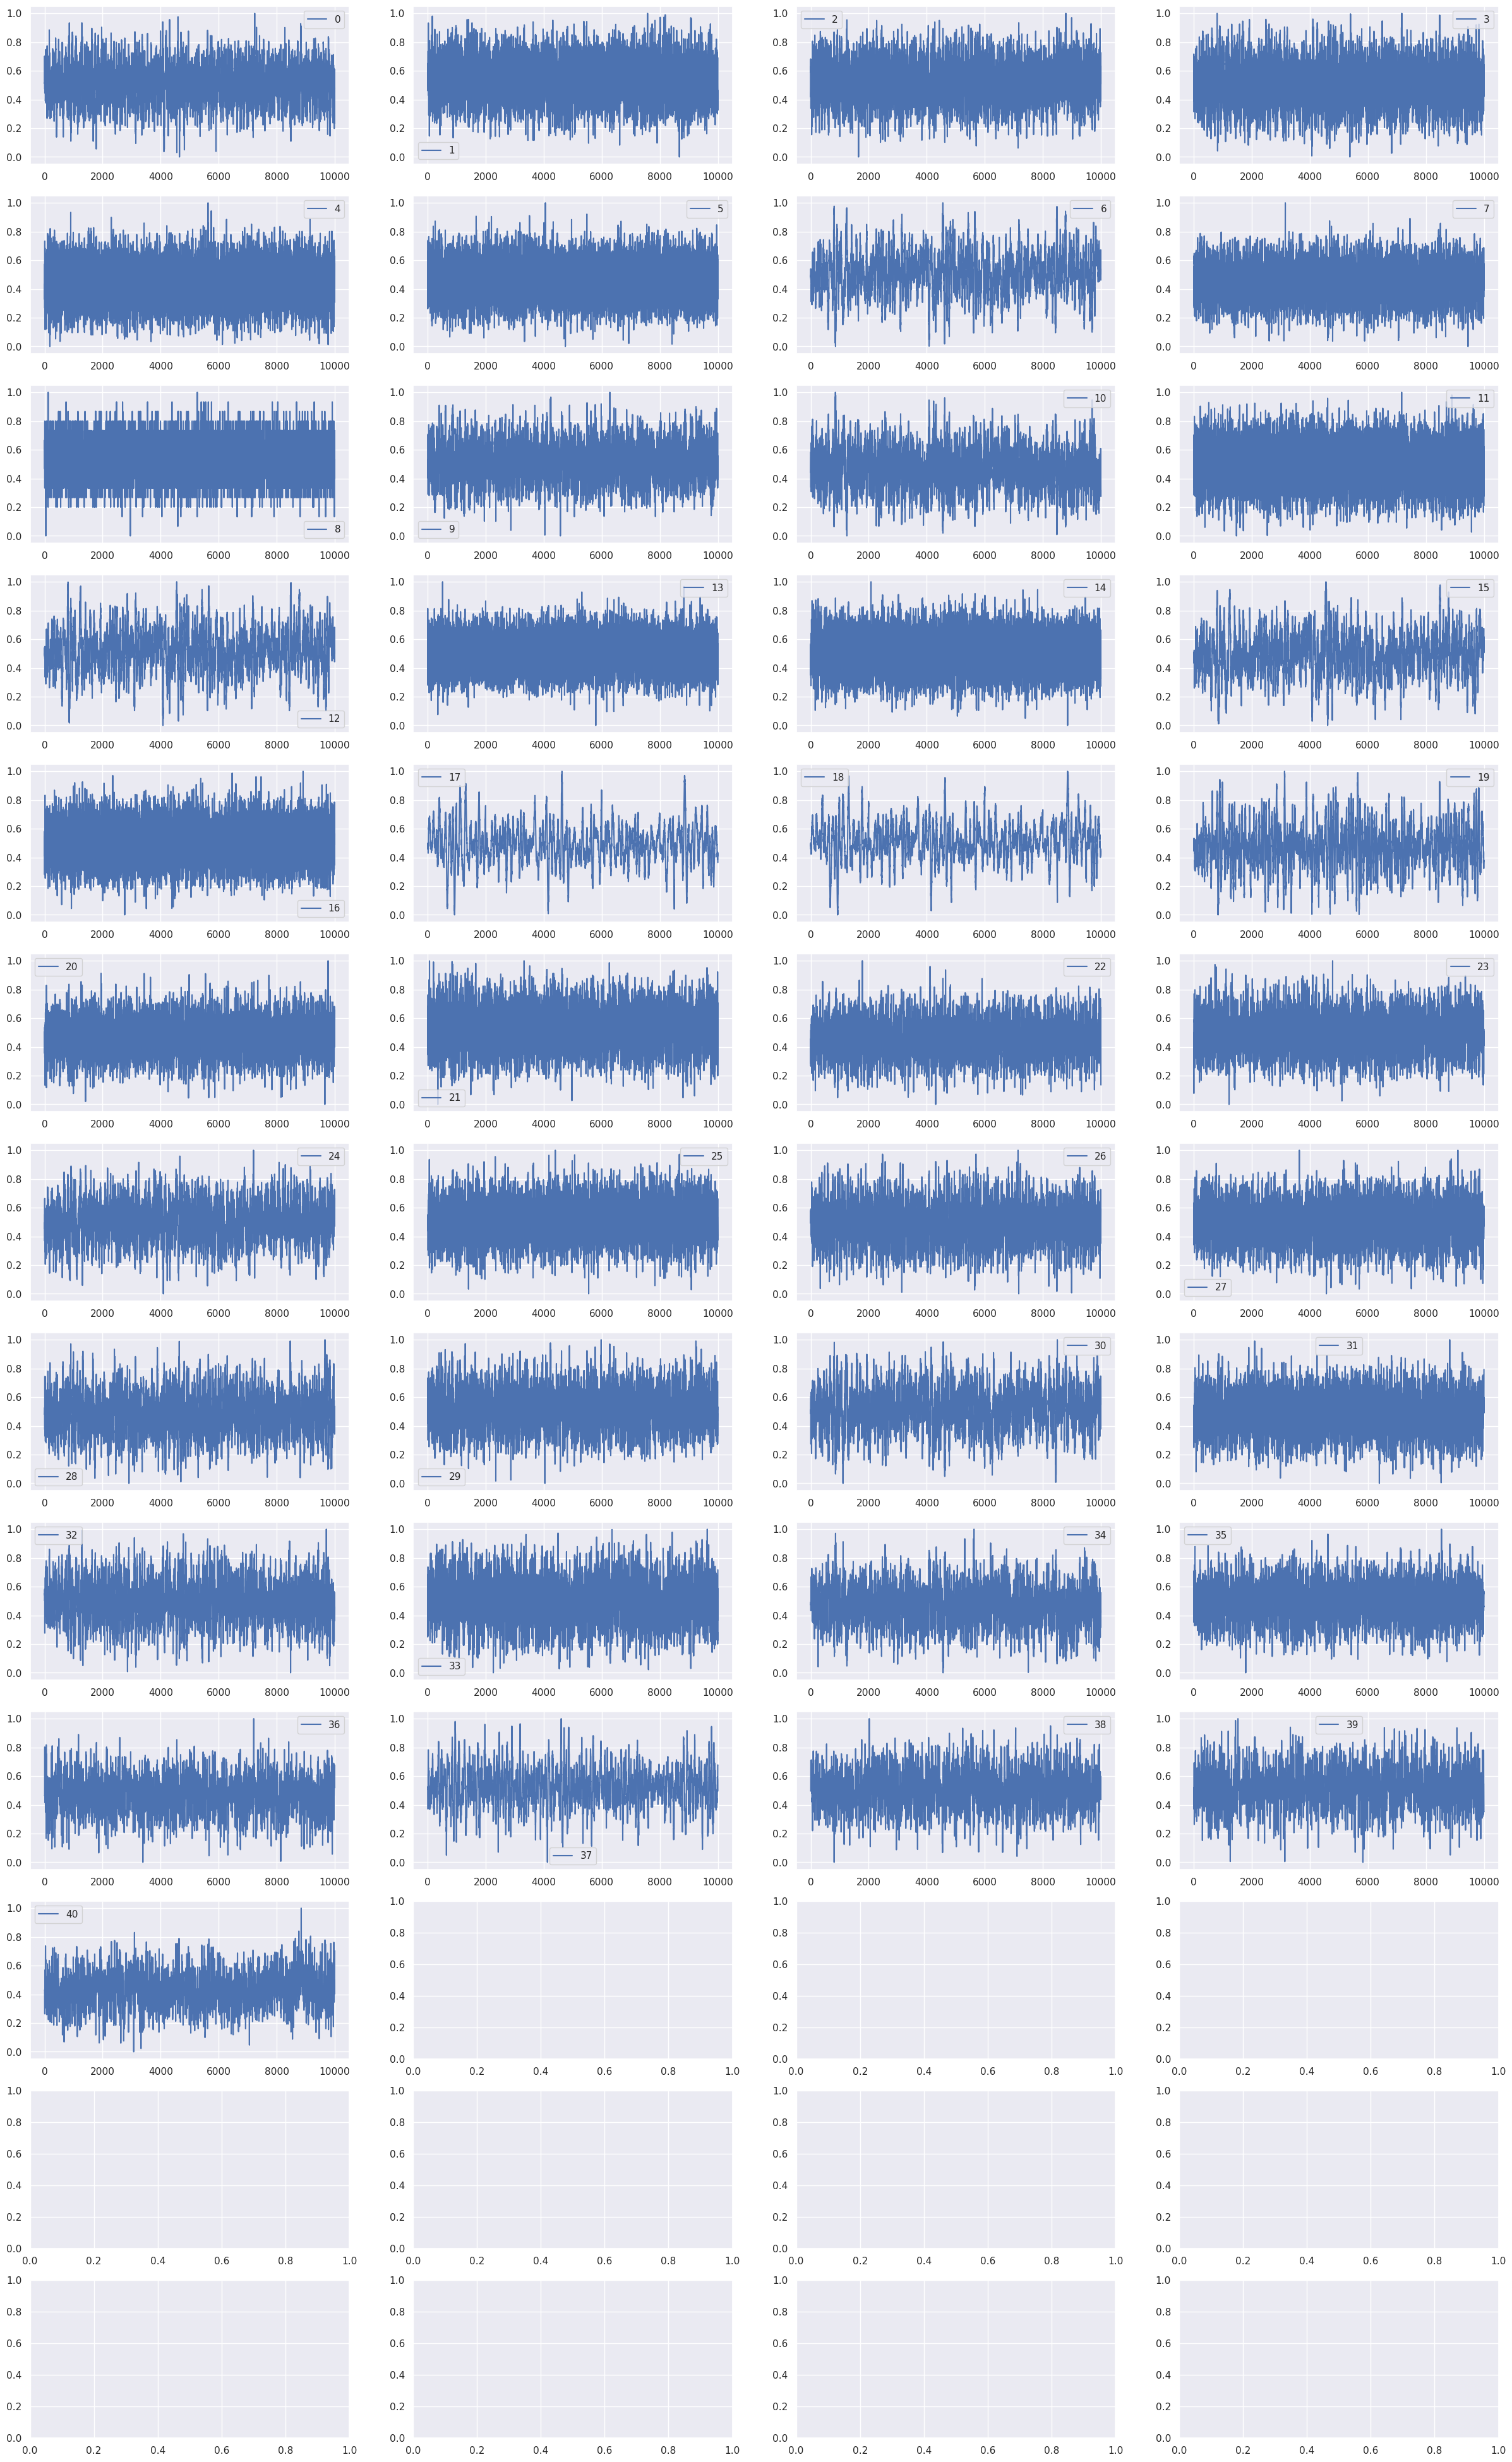

In [441]:
fig, ax = plt.subplots(13,4,figsize=(30,50))

for i in range(train_df_scaled.shape[1]):
    train_df_scaled.iloc[:,i].plot(ax=ax.ravel()[i]) 
    ax.ravel()[i].legend();

Observable, regression, differentiation 설정

In [442]:

# get SVD rank
X1 = X_np[:-1, :]   # (499, 52)
X2 = X_np[1:, :]

U, s, Vh = np.linalg.svd(X1.T, full_matrices=False)
# print(f'U shahpe: {U.shape}')     # (52, 52)
# print(f's shahpe: {s.shape}')     # (52,)
# print(f'Vh shahpe: {Vh.shape}')   # (52, 499)

# A estimation
Aest = np.dot(X2.T,np.dot(Vh.T*(s**(-1)),U.T))  # (52, 52)




In [443]:
# parameters
SVD_RANK = 20
# n_delays = 15-1
n_delays = 100 - 1
INDEX = [1]
n_delays

99

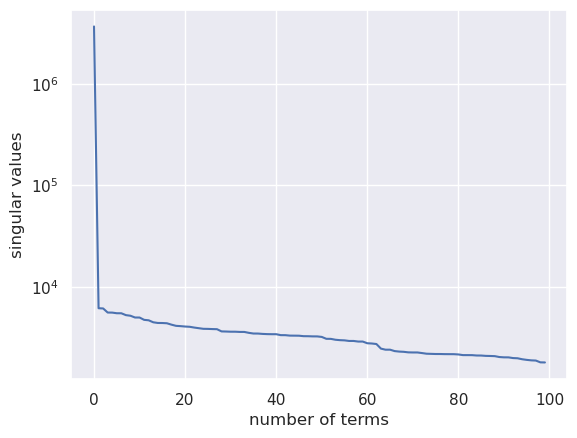

KoopmanContinuous(differentiator=Derivative(k=2, kind='finite_difference'),
                  observables=TimeDelay(n_delays=99),
                  regressor=HAVOK(plot_sv=True, svd_rank=20))

In [444]:
TDC = pk.observables.TimeDelay(delay=1, n_delays=n_delays)
HAVOK = pk.regression.HAVOK(svd_rank=SVD_RANK, plot_sv=True)
Diff = pk.differentiation.Derivative(kind='finite_difference', k=2)  # 4th order
# central difference

model = pk.KoopmanContinuous(observables=TDC, differentiator=Diff, regressor=HAVOK)
model.fit(X_np[:, INDEX], dt=dt)  # Compute model fit using training data

In [445]:
model.B.min()
# print(f'model.A:{model.A}')   # (14, 14)

-3.7822019310244865

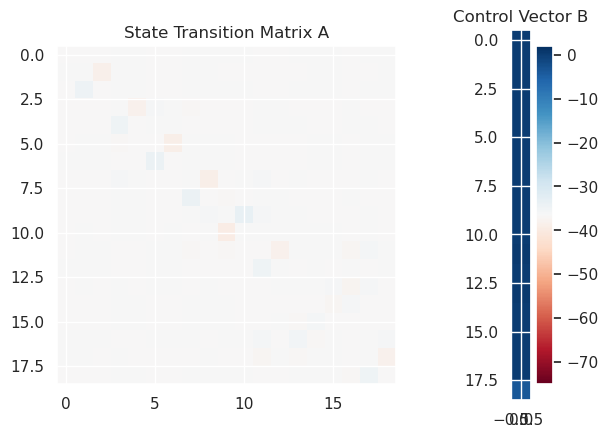

In [446]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[3, 1])

ax0 = plt.subplot(gs[0])
im = ax0.imshow(model.A, aspect='equal', cmap=plt.get_cmap('RdBu'),vmin=-70, vmax=70)
ax0.set(title='State Transition Matrix A')

ax1 = plt.subplot(gs[1])
im = ax1.imshow(model.B, aspect='equal', cmap=plt.get_cmap('RdBu'), vmin=-75, vmax=2)
ax1.set(title='Control Vector B')
fig.colorbar(im, ax=ax1)

### Extract forcing signal
which corresponds to the rth delay vector, here $v_{14}$. The bursts correspond to
lobe switching events of the chaotic Lorenz system.

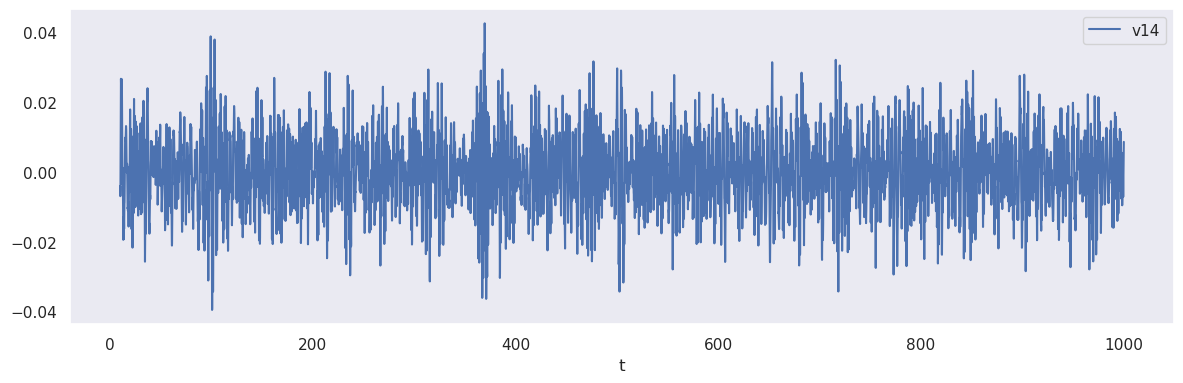

In [447]:
u = model.regressor.forcing_signal
# print(f'u:{u, u.shape}')
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
# print(f't[n_delays:]:{t[n_delays:], t[n_delays:].shape}')
axs.plot(t[n_delays:], u, '-b', label='v14')
axs.grid()
axs.set_xlabel('t')
axs.legend(loc='best')
# plt.xlim([0, 50])
# plt.ylim([-.04, .04])

Predicting using the HAVOK method

In [448]:
xpred = model.simulate(X_np[:n_delays+1, INDEX], t[n_delays:]-t[n_delays], u)

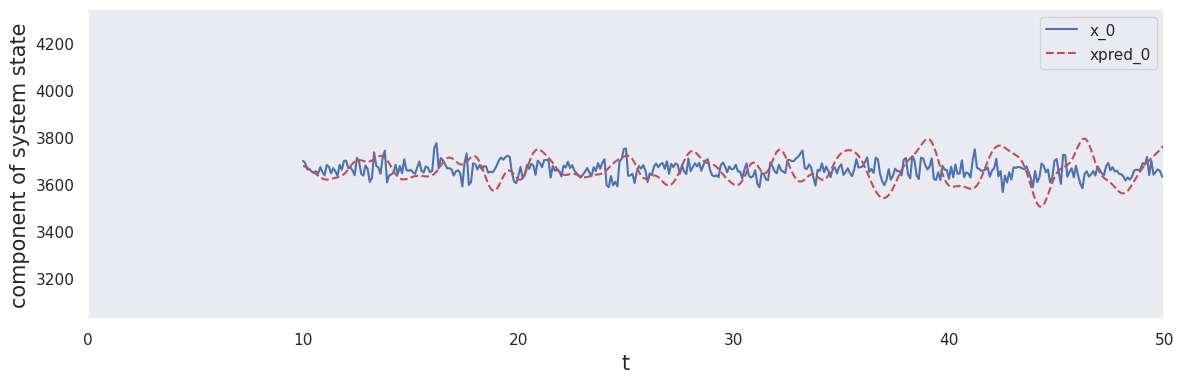

In [449]:
fig, axs = plt.subplots(len(INDEX), 1, tight_layout=True, figsize=(12, 4*len(INDEX)))

if len(INDEX) > 1:
    for i, j in enumerate(INDEX):
        axs[i].plot(t[n_delays:], X_np[n_delays:, j], '-b', label=f'x_{j}')
        axs[i].plot(t[n_delays:], xpred[:,j], '--r', label=f'xpred_{j}')
    for i in range(2):
        axs[i].grid()
        axs[i].set_xlabel('t',size=15)
        axs[i].set_ylabel('component of system state', size=15)
        axs[i].legend(loc='best')
        axs[i].set_xlim([0, 50])
        axs[i].set_ylim([-50, 50])
else:
    axs.plot(t[n_delays:], X_np[n_delays:, INDEX], '-b',  label=f'x_{0}')
    axs.plot(t[n_delays:], xpred, '--r', label=f'xpred_{0}')
    axs.grid()
    axs.set_xlabel('t', size=15)
    axs.set_ylabel('component of system state', size=15)
    axs.legend(loc='best')
    plt.xlim([0, 50])
    # plt.ylim([0, 50])
# axs[1].plot(t[n_delays:], x[n_delays:, 2], '--b', label='x_2')
# axs[1].plot(t[n_delays:], xpred[:,1], '--r', label='xpred_2')



